In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from matplotlib import pyplot as plt
import numpy as np
import math

In [28]:
class ODESegundOrden(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
        batch_size = tf.shape(data)[0]
        min_val = tf.cast(tf.reduce_min(data), tf.float32)
        max_val = tf.cast(tf.reduce_max(data), tf.float32)
        x = tf.random.uniform((batch_size, 1), minval=min_val, maxval=max_val)

        with tf.GradientTape() as tape:
            with tf.GradientTape() as tape2:
                tape2.watch(x)
                with tf.GradientTape() as tape3:
                    tape3.watch(x)
                    y_pred = self(x, training=True)
                dy = tape3.gradient(y_pred, x)
            dy2 = tape2.gradient(dy, x)  # Segunda derivada
            x_o = tf.zeros((batch_size, 1))  # Valor de x en condición inicial x_0=0
            with tf.GradientTape() as T:
                T.watch(x_o)
                y_o = self(x_o, training=True)
            dy_o=T.gradient(y_o,x_o) # derivada en la condicion inicial
            y_o = self(x_o, training=True) # modelo envaluado en la condicion inicial
            eq = dy2 +y_pred  # Ecuación diferencial evaluada en el modelo
            ic = 1.0  # Valor deseado para la condición inicial o el modelo en x_0
            ic2= -0.5 # de la condicion inicial para la derivada 
            loss = self.mse(0., eq) + self.mse(y_o, ic) + self.mse(dy_o, ic2)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [29]:
class ODECoseno(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        
        batch_size = tf.shape(data)[0]
        min = tf.cast(tf.reduce_min(data),tf.float32)
        max = tf.cast(tf.reduce_max(data),tf.float32)
        x = tf.random.uniform((batch_size,1), minval=min, maxval=max)

        with tf.GradientTape() as tape:
            with tf.GradientTape() as tape2:
                tape2.watch(x)
                y_pred = self(x, training=True)
            dy = tape2.gradient(y_pred, x) #derivada respecto a x
            x_o = tf.zeros((batch_size,1)) #condicion inicial x_0=0
            y_o = self(x_o,training=True) #valor del modelo en en x_0
            eq = x*dy + y_pred - tf.math.pow(x,2.)*tf.math.cos(x) #Ecuacion diferencial evaluada 
            ic = 0. #valor de la condicion inicial.
            loss = self.mse(0., eq) + self.mse(y_o,ic)

        # Apply grads
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {"loss": self.loss_tracker.result()}

In [30]:
model = ODESegundOrden()

model.add(Dense(20, activation='tanh', input_shape=(1,)))
model.add(Dense(1, activation='tanh'))
model.add(Dense(1))


model.summary()

model2 = ODECoseno()

model2.add(Dense(20, activation='tanh', input_shape=(1,)))
model2.add(Dense(1, activation='tanh'))
model2.add(Dense(1))


model2.summary()

Model: "ode_segund_orden_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 20)                40        
                                                                 
 dense_19 (Dense)            (None, 1)                 21        
                                                                 
 dense_20 (Dense)            (None, 1)                 2         
                                                                 
Total params: 63 (252.00 Byte)
Trainable params: 63 (252.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model: "ode_coseno_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 20)                40        
                                                                 
 dense_22 (Dense)            (None, 1)                 21        
                                                                 
 dense_23 (Dense)            (None, 1)                 2         
                                                                 
Total params: 63 (252.00 Byte)
Trainable params: 63 (252.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


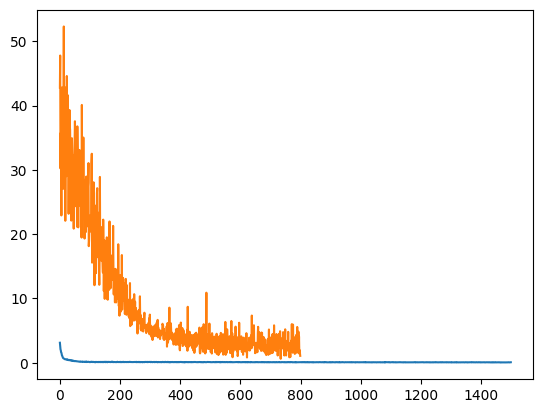

In [31]:
model.compile(optimizer=RMSprop(),metrics=['loss'])

x=tf.linspace(-5,5,100)
history = model.fit(x,epochs=1500,verbose=0)
plt.plot(history.history["loss"])

model2.compile(optimizer=RMSprop(),metrics=['loss'])

x=tf.linspace(-5,5,100)
history = model2.fit(x,epochs=800,verbose=0)
plt.plot(history.history["loss"])

4/4 [==============================] - 0s 2ms/step


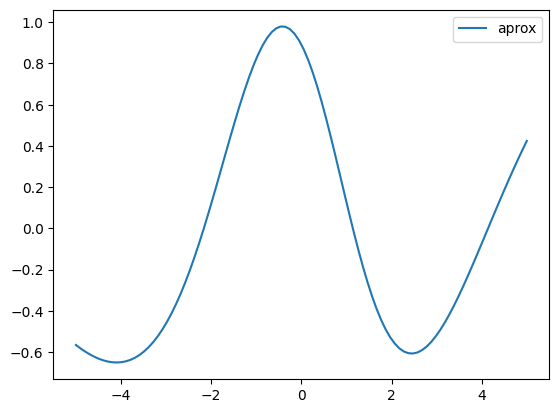

In [32]:
x_testv = tf.linspace(-5,5,100)
a=model.predict(x_testv)
plt.plot(x_testv,a,label="aprox")
plt.legend()
plt.show()

4/4 [==============================] - 0s 2ms/step


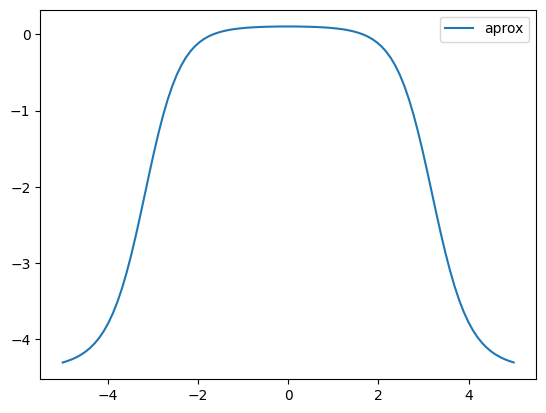

In [33]:
x_testv = tf.linspace(-5,5,100)
b=model2.predict(x_testv)
plt.plot(x_testv,b,label="aprox")
plt.legend()
plt.show()